# Recommender ChatBot: Update Users and Items embeddings using DeepFM model

Generate users/items embeddings using DeepFM collaborative filtering model Then store embeddings into a chromadb database.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

BASE_PATH    = '../..'
LIB_PATH     = f'{BASE_PATH}/lib'
API_PATH     = f'{BASE_PATH}/chat-bot-api'


os.environ['TMP_PATH']               = f'{BASE_PATH}/tmp'
os.environ['DATASET_PATH']           = f'{BASE_PATH}/datasets'
os.environ['WEIGHTS_PATH']           = f'{BASE_PATH}/weights'
os.environ['METRICS_PATH']           = f'{BASE_PATH}/metrics'
os.environ['MONGODB_URL']            = 'mongodb://0.0.0.0:27017'
os.environ['MONGODB_DATABASE']       = 'chatbot'
os.environ['CHROMA_HOST']            = '0.0.0.0'
os.environ['CHROMA_PORT']            = '9090'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [3]:
import sys
sys.path.append(LIB_PATH)
sys.path.append(API_PATH)


import torch
import pytorch_common
import pytorch_common.util as pu
import util as ut
import pandas as pd
import service as srv
import os
from bunch import Bunch
import logging

from data.plot import describe_num_var
from services import ItemSimQuery
from app_context import AppContext
from jobs import CFEmbUpdateJobHelper

<Figure size 640x480 with 0 Axes>

## Setup

In [4]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [5]:
import pytorch_common
pytorch_common.__version__

'0.3.8'

In [6]:
torch.__version__

'2.2.1+cu118'

In [7]:
pu.set_device_name('gpu')

pu.get_device(), torch.cuda.is_available()

(device(type='cuda', index=0), True)

In [8]:
ut.set_seed(42)

In [9]:
def to_df(items, distances):
    items_df = pd.DataFrame.from_records([i.model_dump(exclude_none=True) for i in items])
    items_df['distance'] = distances
    return items_df.loc[:, ~items_df.columns.isin(['embedding'])]

In [10]:
async def similars(content, limit):
    items, distances = await ctx.item_service.find_similars_by(
        ItemSimQuery() \
            .contains(content) \
            .limit_eq(limit)
    )

    items_df = to_df(items, distances)

    print(items_df.iloc[0,:].title)
    
    item  = ctx.items_cf_emb_repository.find_by_id(items_df.iloc[0,:].id)


    similars = ctx.items_cf_emb_repository.find_similar_by_id(
        item.id,
        limit=limit,
    )

    similars_df = pd.DataFrame(
        data={
            'id'       : [str(i) for i in similars.ids],
            'distance' : similars.distances
        }
    )

    similar_items = await ctx.item_service \
        .find_by_ids([str(s) for s in similars.ids])


    similar_items_df = pd.DataFrame \
        .from_records([i.dict(exclude_none=True) for i in similar_items])


    similar_items_df = similar_items_df \
        .merge(similars_df, on=['id'])[['distance', 'rating', 'id', 'title', 'genres', 'release']] \
        .sort_values(by=['distance'])

    return similar_items_df

In [11]:
def filter_by_geners(similar_items_df, genres):
    genres = set(genres)

    genres_similar_items_df = similar_items_df[similar_items_df.genres.apply(lambda x: genres.issubset(set(x))) ]
    
    return genres_similar_items_df \
        .sort_values(by=['distance'])

## Prepare dataset

In [12]:
ctx = AppContext()

2024-04-21 15:55:55,370 - INFO - Load pretrained SentenceTransformer: all-mpnet-base-v2
2024-04-21 15:55:58,253 - INFO - Use pytorch device_name: cuda
2024-04-21 15:55:58,352 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
2024-04-21 15:55:58,371 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


In [13]:
helper = CFEmbUpdateJobHelper(ctx)

In [14]:
interactions_df = helper.get_interactions()
train_set, test_set = helper.split_dataset(interactions_df)

2024-04-21 15:55:58,420 - INFO - GET http://nonosoft.ddns.net:8080/api/v1/interactions
2024-04-21 15:56:02,690 - INFO - Train: 74.40 % - Test: 4.21 %


## Train model

In [15]:
model_loader = srv.DeepFMLoader(
    weights_path          = os.environ['WEIGHTS_PATH'],
    metrics_path          = os.environ['METRICS_PATH'],
    tmp_path              = os.environ['TMP_PATH'],
    user_seq_col          = 'user_seq',
    item_seq_col          = 'item_seq',
    update_period_in_min  = 1,
    params              = Bunch({
        'model': Bunch({
            'units_per_layer'   : [20, 1],
            'dropout'           : 0.25,
            'embedding_size'    : 50,
        }),
        'train': Bunch({
            'lr'         : 0.001,
            'lr_factor'  : 0.1,
            'lr_patience': 6,
            'epochs'     : 7,
            'n_workers'  : 24,
            'batch_size' : 2048,
            'eval_percent': 0.15
        }),
        'metrics': Bunch({
            'n_samples'  : 250,
            'batch_size' : 2000
        })
    })
)

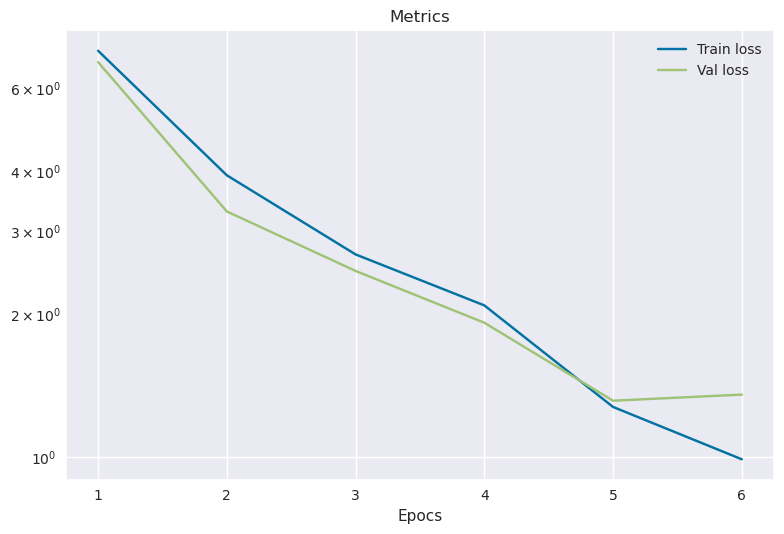

2024-04-21 15:56:44,096 - INFO - {'time': '0:00:05.68', 'epoch': 7, 'train_loss': 0.9341236677239922, 'val_loss': 1.3329532146453857, 'lr': 0.001}


Computing metrics using validation set:   0%|          | 0/250 [00:00<?, ?it/s]

Ordered by mAP@5(4,5):


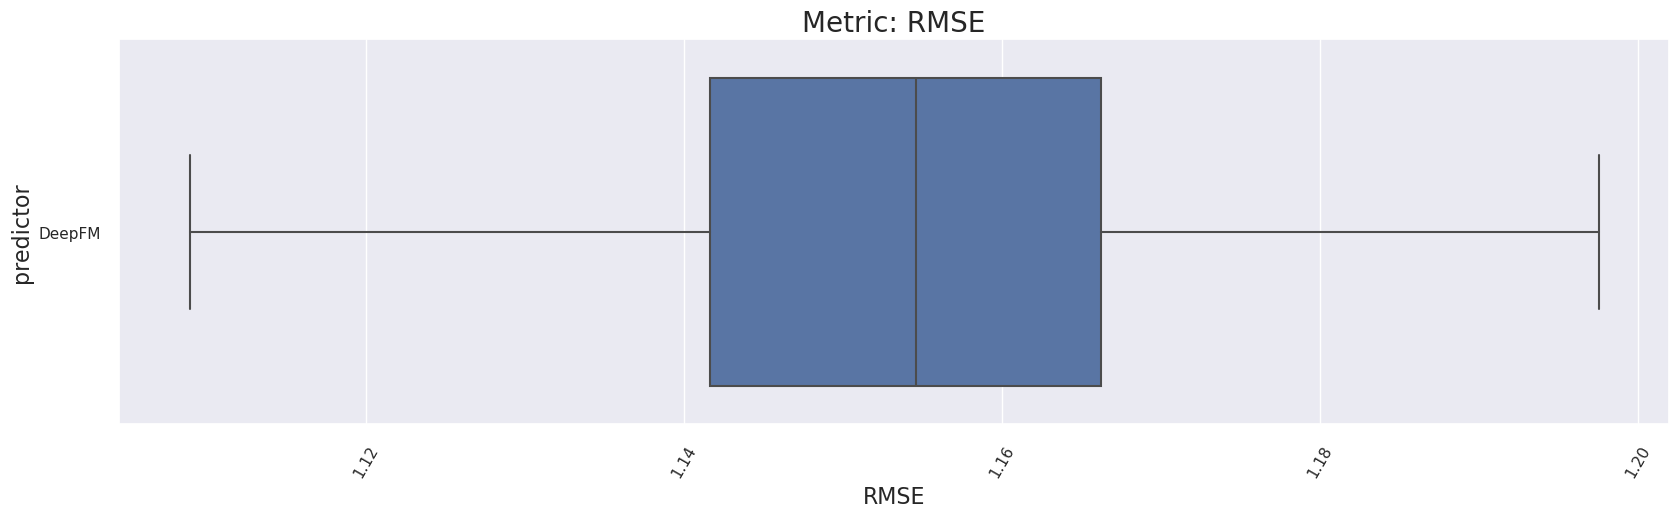

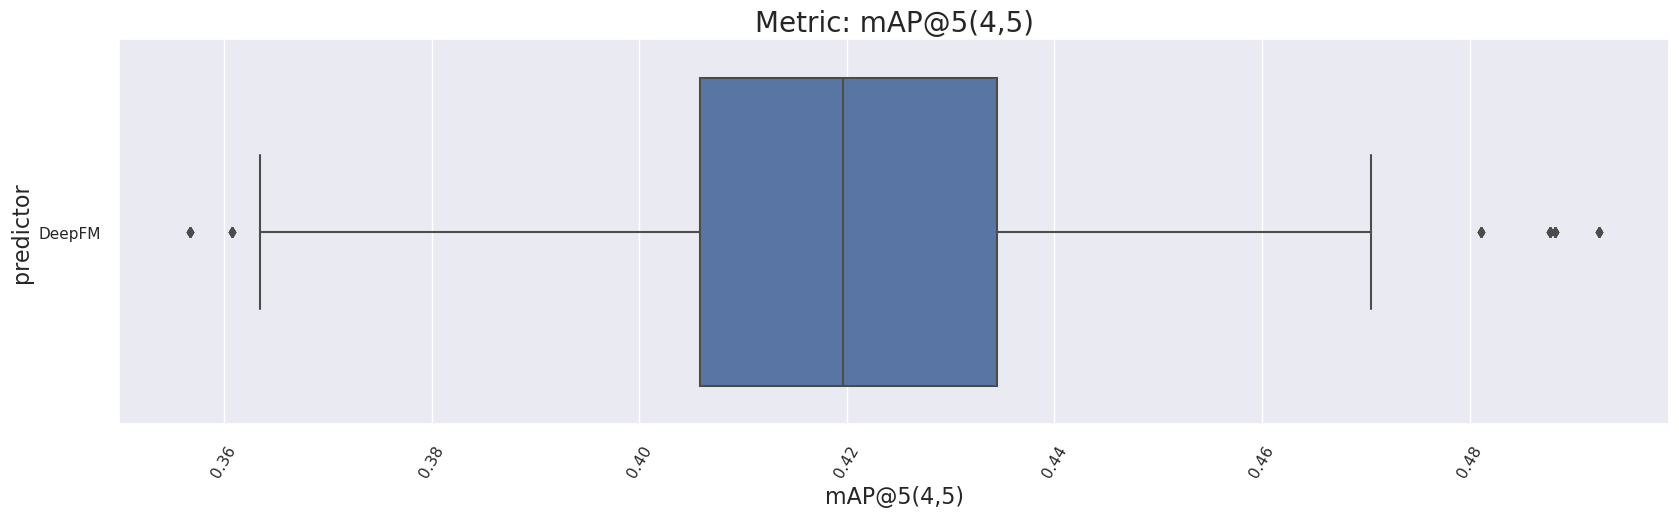

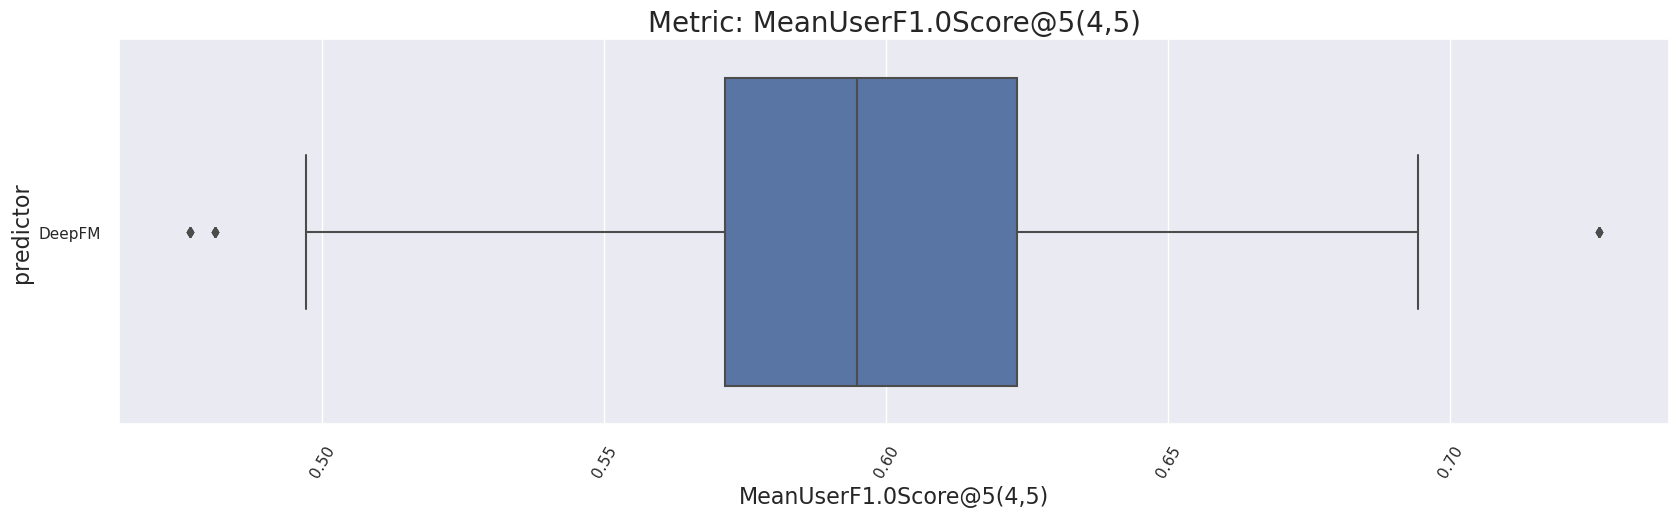

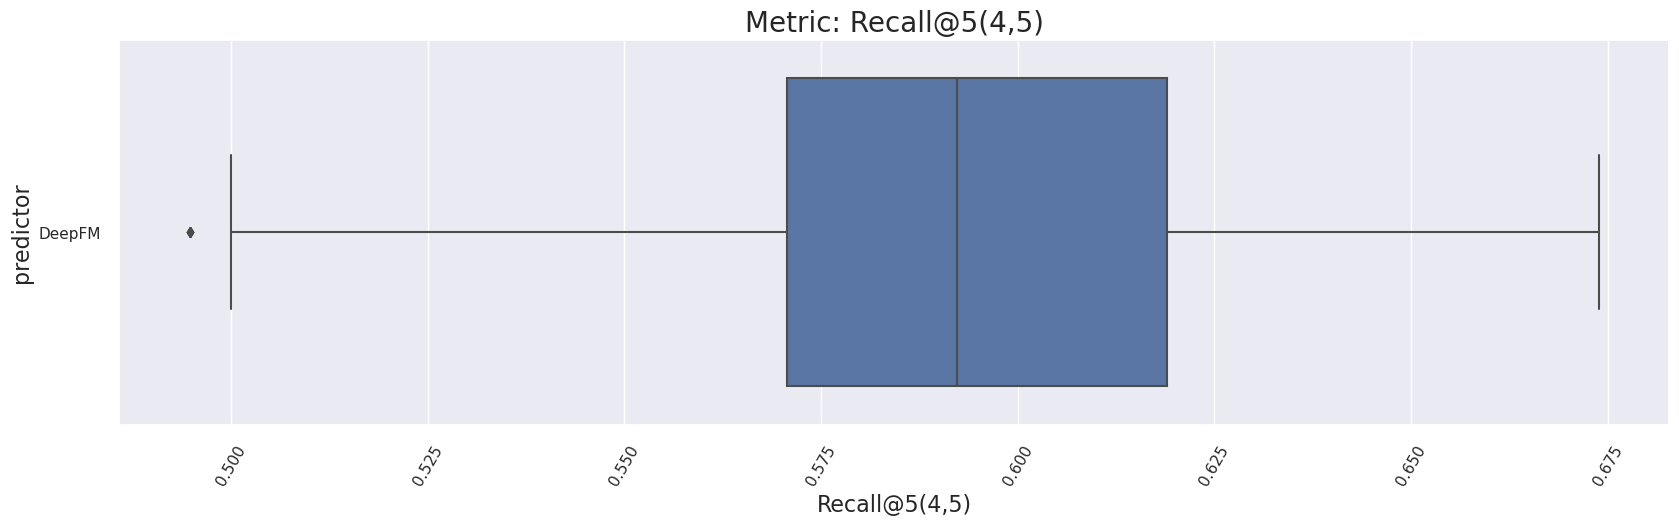

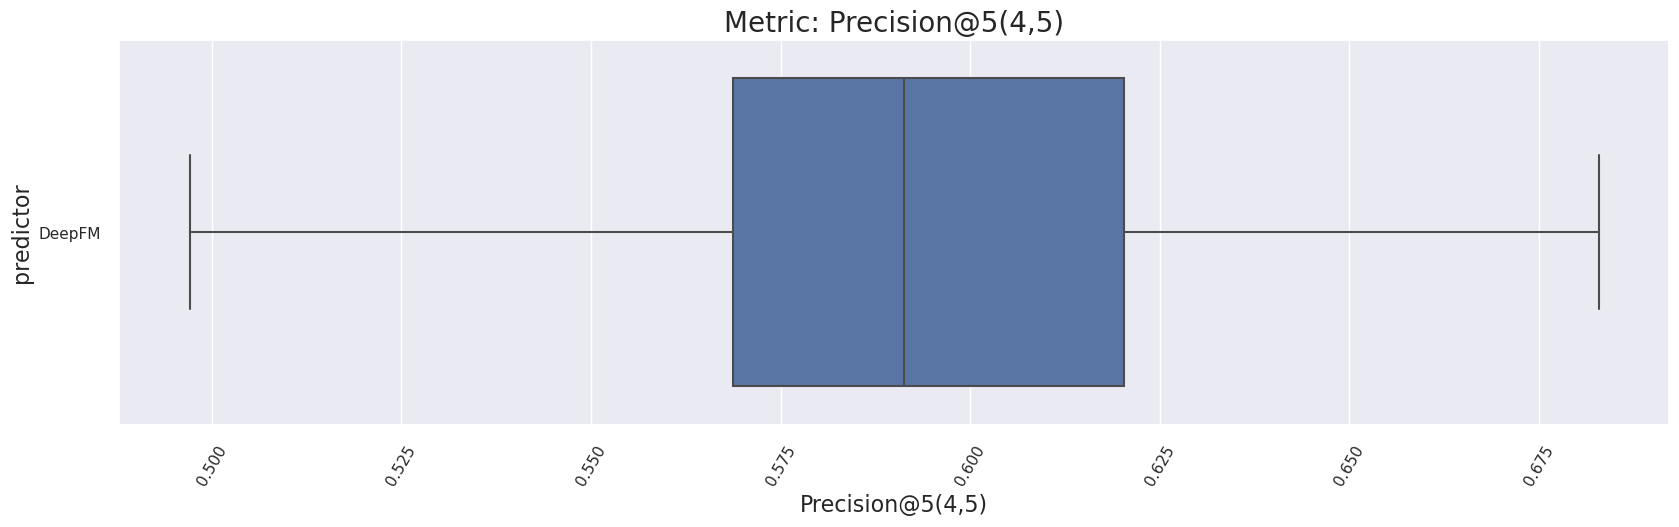

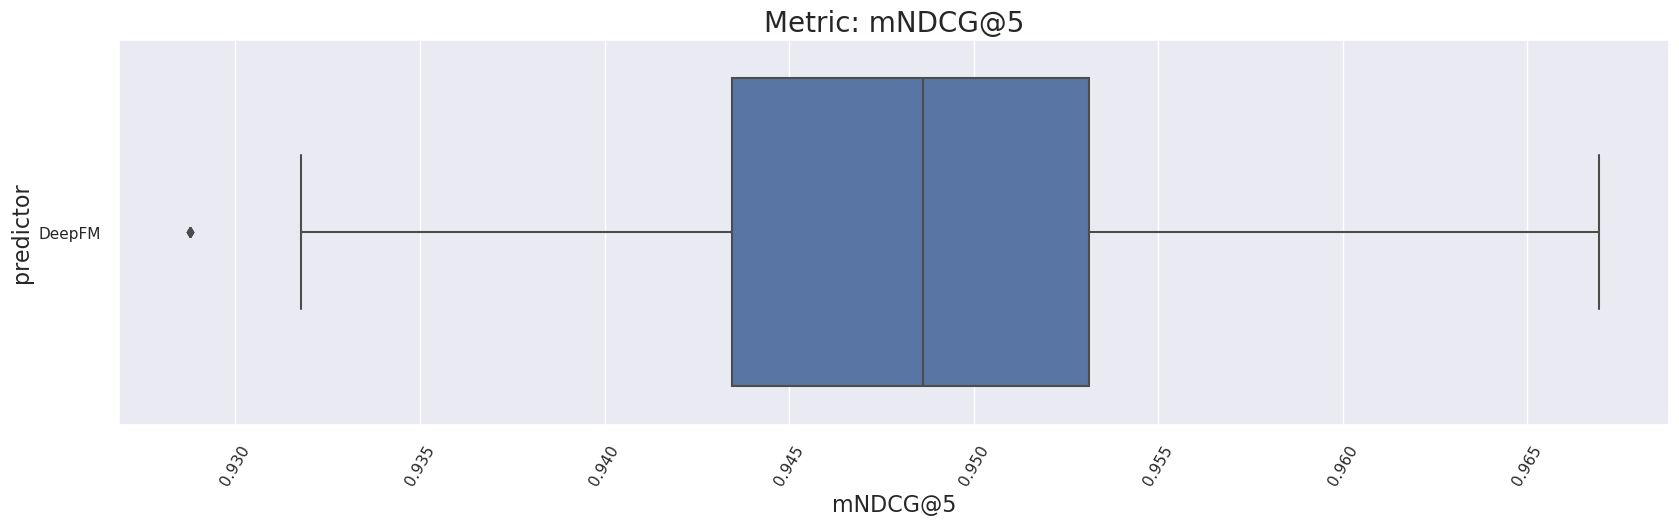

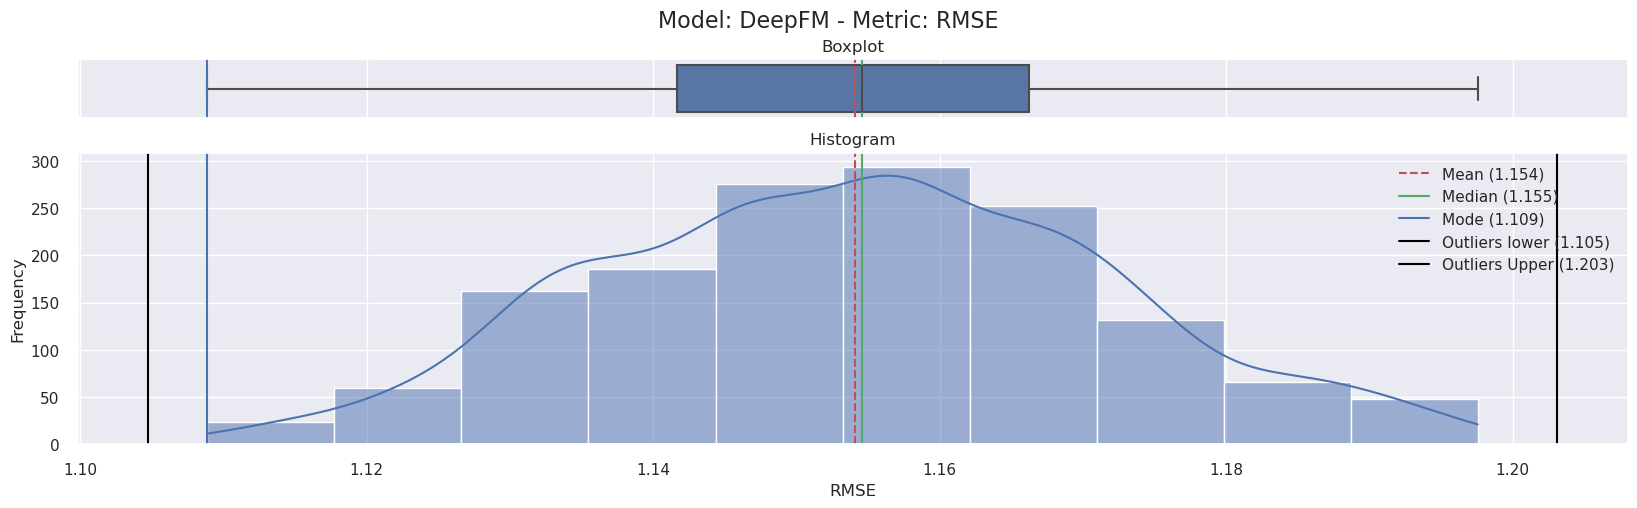

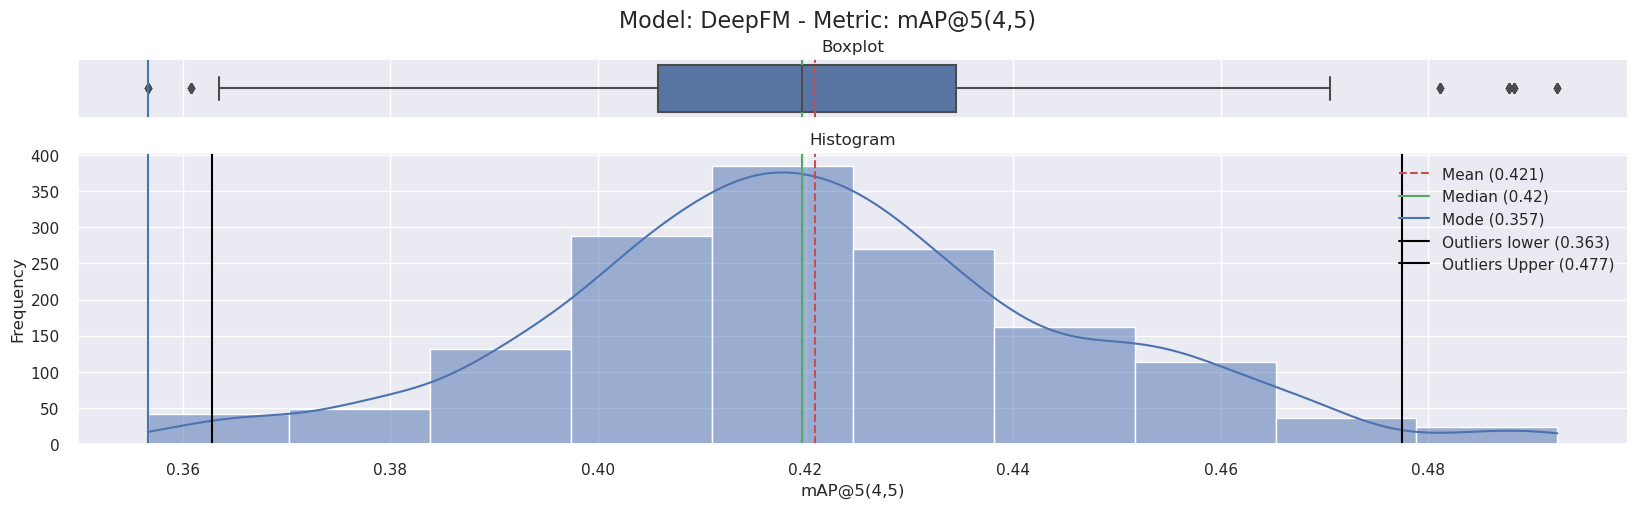

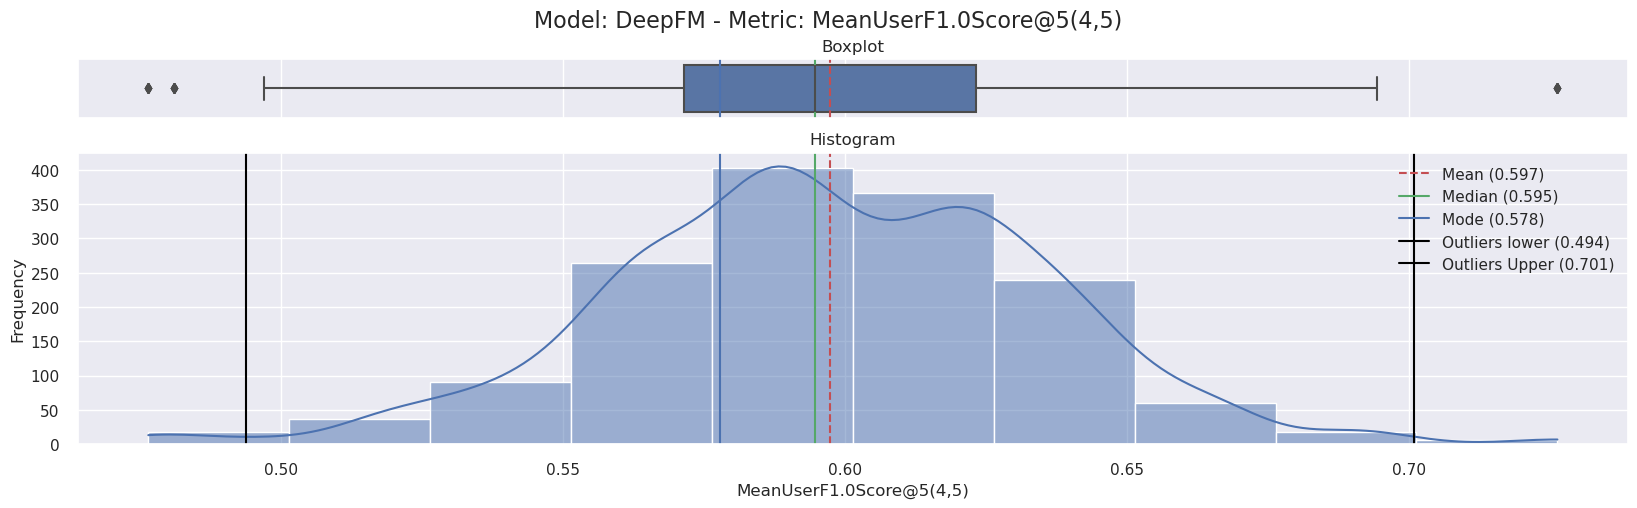

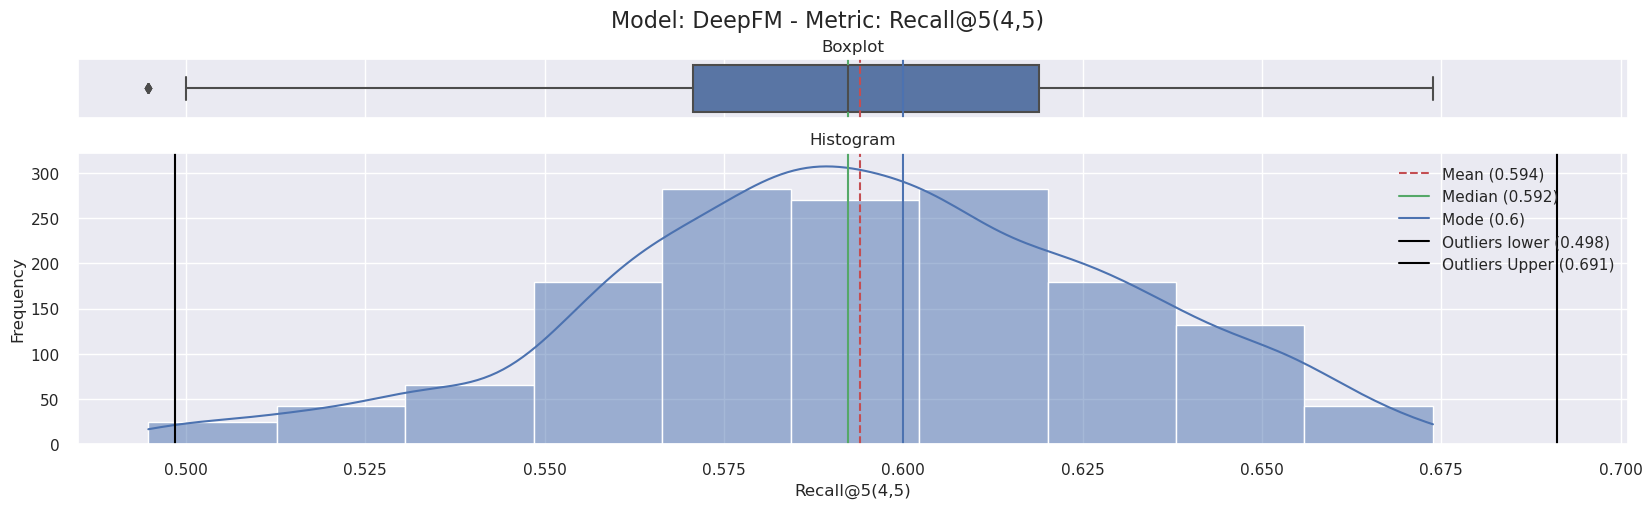

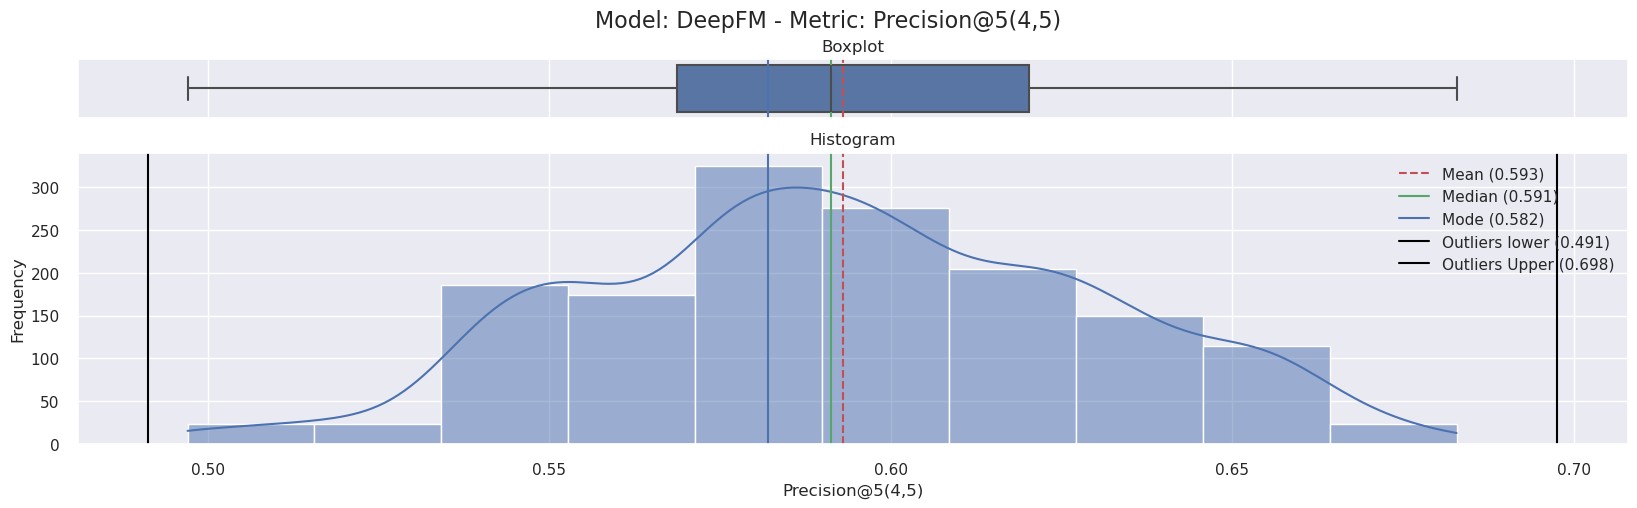

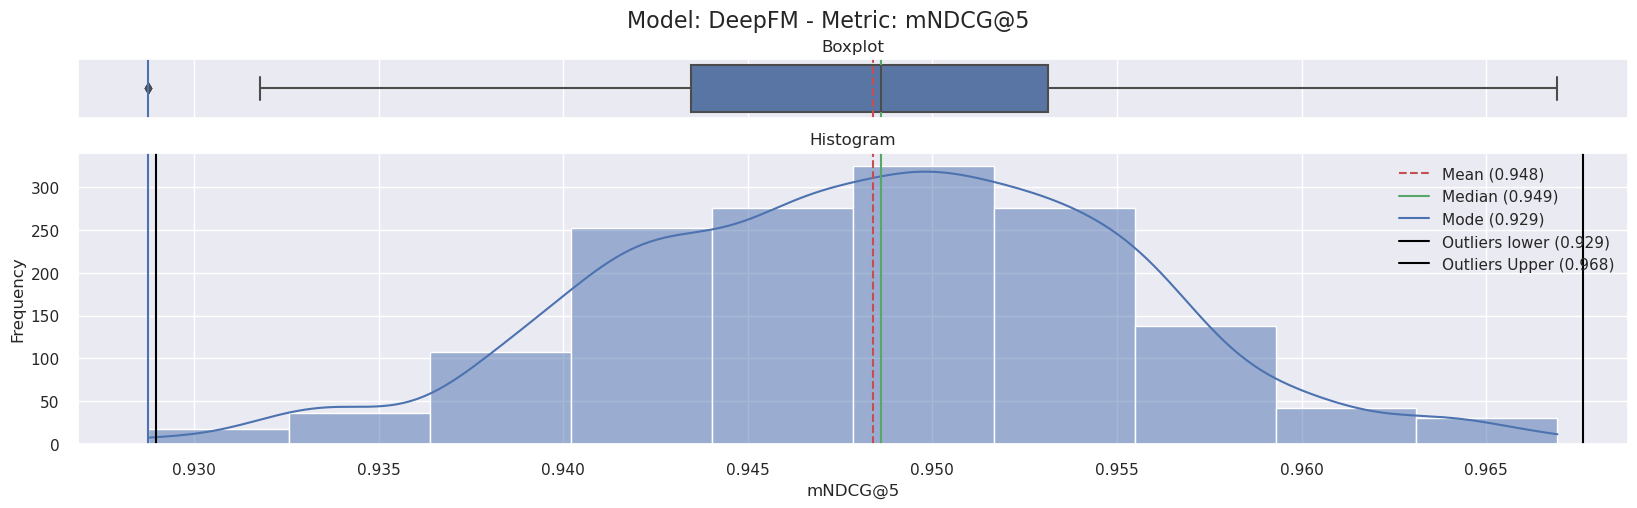

In [16]:
model, params = model_loader.load(train_set, test_set)

## Update users and items embeddings into chroma-db

In [17]:
helper.update_embeddings(model, train_set)

2024-04-21 15:57:14,220 - INFO - Get feature 0 embeddings [1653, 50]. Detail: Embeddings from 0 to 1652 from weights [18554, 50]
2024-04-21 15:57:14,221 - INFO - Get feature 1 embeddings [16901, 50]. Detail: Embeddings from 1653 to 18553 from weights [18554, 50]


Insert embeddings into "users_cf" collection (chroma-db):   0%|          | 0/1653 [00:00<?, ?it/s]

Insert embeddings into "items_cf" collection (chroma-db):   0%|          | 0/16901 [00:00<?, ?it/s]

## Simple item embeddings evaluation

In [18]:
similars_df = await similars('Toy Story', limit=14000)

Toy Story

/var/tmp/ipykernel_494897/1620873849.py:32: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  .from_records([i.dict(exclude_none=True) for i in similar_items])


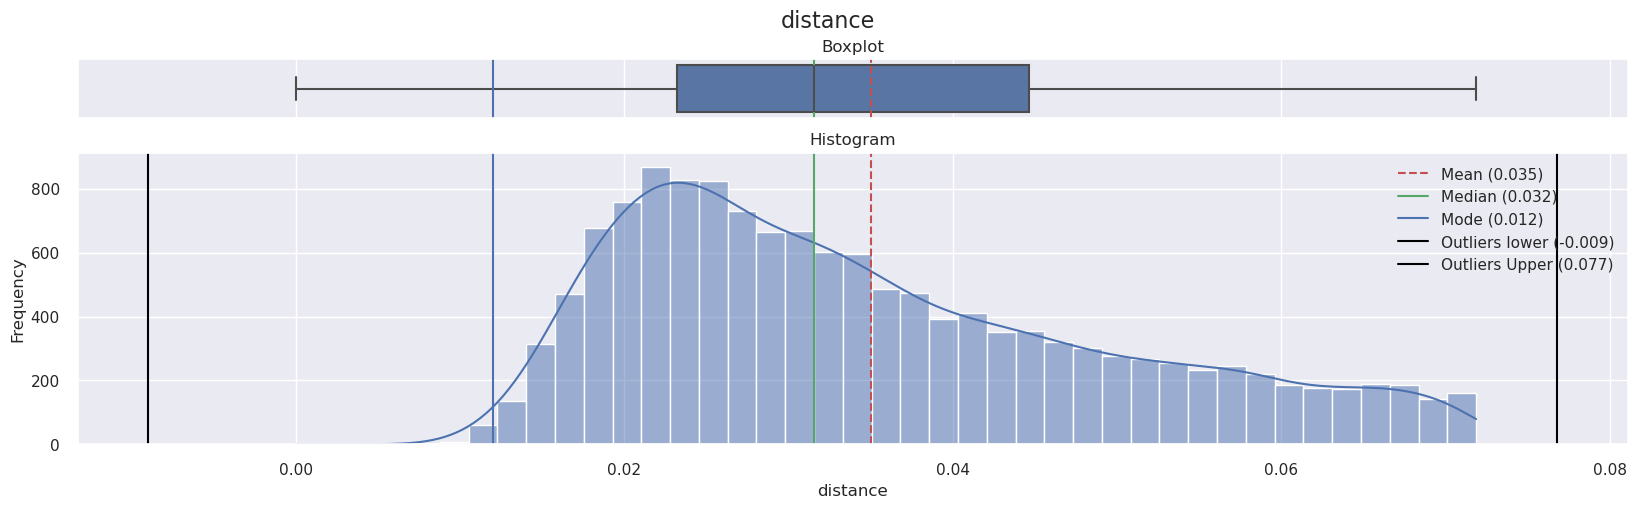

In [19]:
describe_num_var(similars_df, 'distance')

**Observaciones**

* Si visualizamos ls distribucion de distancias de todos los items al item en cuestión, se aprecia que es una distrubución sesgada a izquierda, es decir que los datos se concentran a izquierda.
* La moda es menor a la media dado que hay una concetracion de valores menos tipicos a derecha que empizan a al meda a derecha. La Moda se encuentra a la zquierca de la emdia ya que en ese sector se contrentra la mayor cantidad de valores.
* Esto no dice que hay mas items cercanos que lejanos. Esto item lejanos podemos verlos como valores atipicos, ya que el centro de la districion se encuentra mas cercano al item buscado.

In [20]:
genres_similars_df = filter_by_geners(similars_df, ['animation', 'adventure', 'children'])
genres_similars_df.head()

,distance,rating,id,title,genres,release
0,0.000000,3.806931,1,Toy Story,"[adventure, animation, children, comedy, fantasy]",1995
13151,0.010800,3.826316,8961,"Incredibles, The","[action, adventure, animation, children, comedy]",2004
1896,0.013183,3.000000,128540,The Gruffalo's Child,"[adventure, animation, children, fantasy]",2011
5425,0.014271,3.587302,2355,"Bug's Life, A","[adventure, animation, children, comedy]",1998
4247,0.014928,3.727273,166461,Moana,"[adventure, animation, children, comedy, fantasy]",2016


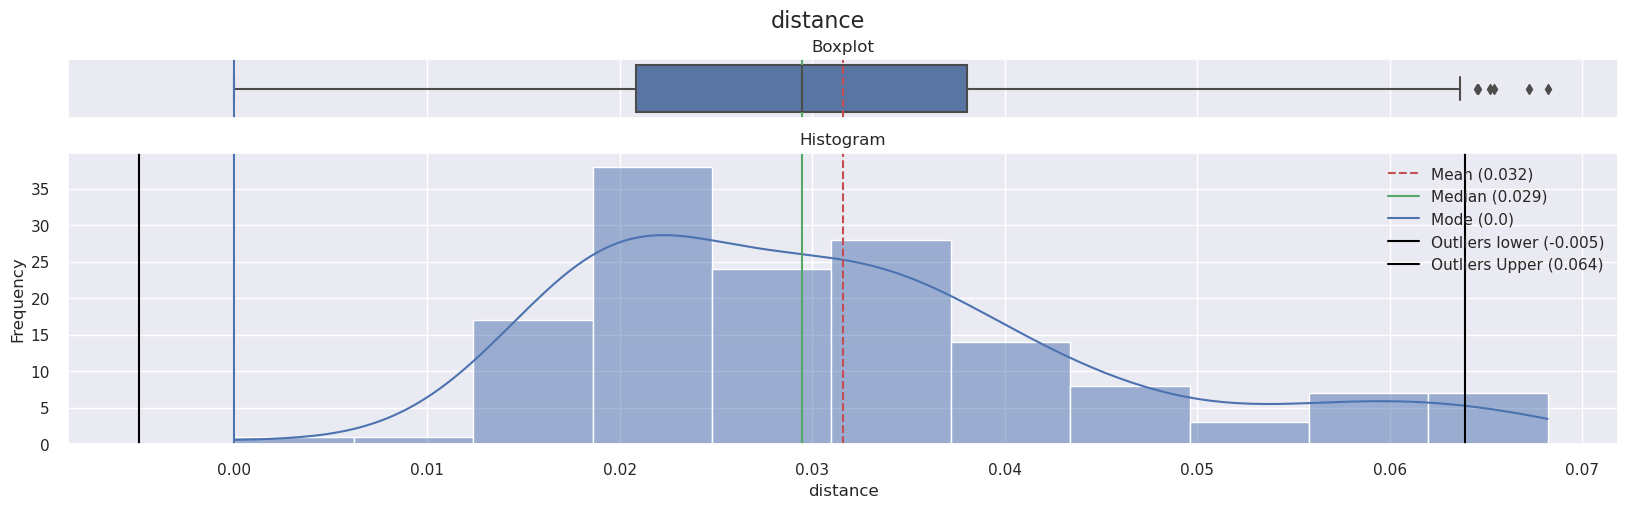

In [21]:
describe_num_var(genres_similars_df, 'distance')

**Observaciones**
 
    
* Si acotamos la districión a los items mas similares al item en cuestión vemos que la mediana de las distnacias es de 0.025. Esto nos dice que los items de generos similares se encuentra a la izquierda de la media del la districión de la figura anterior. 

Toy Story

/var/tmp/ipykernel_494897/1620873849.py:32: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  .from_records([i.dict(exclude_none=True) for i in similar_items])


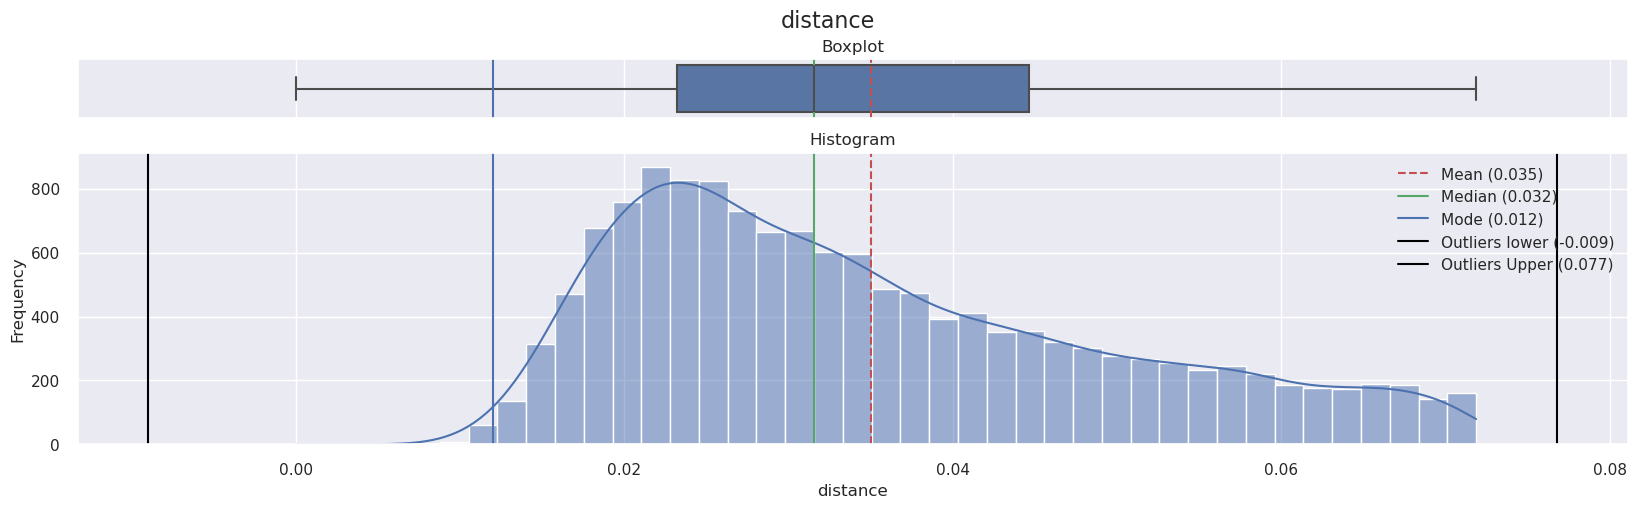

In [22]:
similars_df2 = await similars('Terminator', limit=14000)

describe_num_var(similars_df2, 'distance')

In [23]:
genres_similars_df2 = filter_by_geners(similars_df2, ['action', 'adventure', 'sci-fi', 'thriller'])
genres_similars_df2.head()

,distance,rating,id,title,genres,release
10380,0.011270,3.442623,6365,"Matrix Reloaded, The","[action, adventure, sci-fi, thriller, imax]",2003
1605,0.015479,3.862832,122882,Mad Max: Fury Road,"[action, adventure, sci-fi, thriller]",2015
11886,0.017909,3.430769,77561,Iron Man 2,"[action, adventure, sci-fi, thriller, imax]",2010
7328,0.018586,3.625000,3703,"Road Warrior, The","[action, adventure, sci-fi, thriller]",1981
12806,0.019379,3.574324,8644,"I, Robot","[action, adventure, sci-fi, thriller]",2004


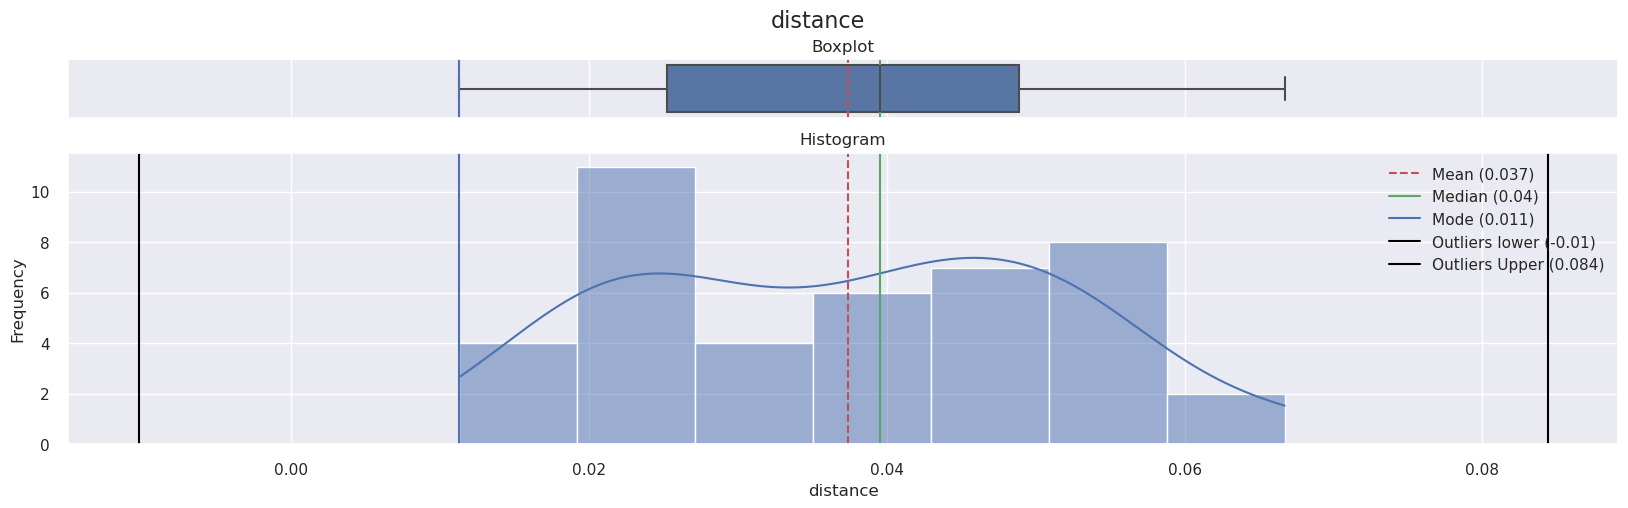

In [24]:
describe_num_var(genres_similars_df2, 'distance')

**Observaciones**

En resumen, los embeddings que representan a los items aprendidos por el modelo a apartir de las calificaciones de los usuario, parecen 
haber captado similitud por generos. Ya que idesm con generosmas similares parece ser ams sercanos al item en cuestión. 
Por supuesto que esto no es una relación directa, pero en ambos casos la media de los items con generos similares parecen estar a izquierda de la distribución no filtrada por generos. 

## Upsert predicted interactions


In [ ]:
await helper.update_database(train_set, model)